# Classification

## Dowloading MNIST Dataset

In [14]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [15]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [16]:
y.shape

(70000,)

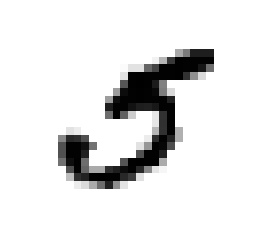

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

## Train set & Test set

In [7]:
# This dataset is split in training set (60000) and test set (10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

## Performance Measures

### Measuring Accuracy using Cross-Validation

In [11]:
# Defining my own cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0
0
0


In [12]:
# Now using cros_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9655 ,  0.95955,  0.96795])

In [13]:
# Demostrating accuracy is not a good scoring measure
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Above 90% because 10% of the datasets has 5s,so mosy of the time guess no 5s

array([ 0.9113 ,  0.9058 ,  0.91185])

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[54015,   564],
       [ 1576,  3845]])

In [16]:
TN,FP,FN,TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1] # True negative, False positive, False negative, True positive

**Precision:** accuracy of the positive predictions

$ precision = \frac{TP}{TP +TF} $

In [17]:
precision = TP/(TP+FP)
precision

0

**Recall (sensitivity or true positive rate (TPR)):** ratio of positive instances that are correctly detected by the classifier

$recall = \frac{TP}{TP+FN}$

In [18]:
recall = TP/(TP+FN)
recall

0

**Precision & Recall** from Sci-kit learn

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) ## Classifier is correct 63% of the time

0.87207983669766387

In [20]:
recall_score(y_train_5, y_train_pred) ## Classifier detects 85% of the 5s

0.70927873086146465

**$F_1$ score**: combine precision & recall, used to compare two classifiers. Use the harmonic mean because a differemce with normal mean, this one gives much more weight to low values. Then, result gets a high $F_1$ score if both precision & recall are high.

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 * \frac{precision*recall}{precision+recall} = \frac{TP}{TP+\frac{FN+Fp}{2}}$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78229908443540186

**Precision & recall tradeoff**: increasing precision, reduces recall and vice versa.

In [60]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [61]:
from sklearn.metrics import  precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

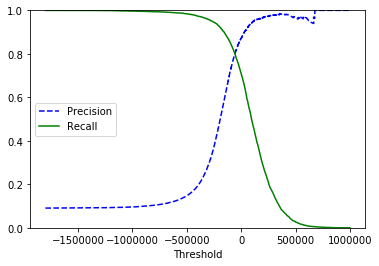

In [62]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### The ROC CURVE

The receiver operating characteristic used with binary classifiers, the ROC curve plots _true positive rate_ (recall) against _false positive rate_

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

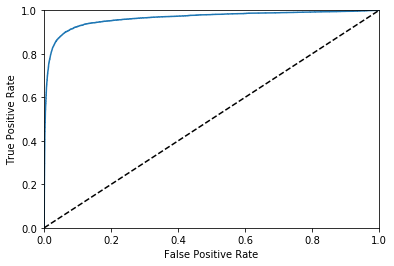

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)

Perfect classifier an area under the curve (ROC AUC) = 1

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96422329640695326

**Plotting ROC Curve with _RandomForestClassifier_**

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [29]:
y_score_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

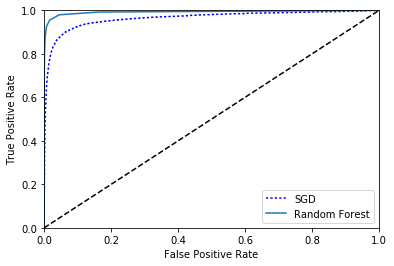

In [30]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_score_forest)

0.99259031819147636

In [32]:
from sklearn.model_selection import cross_val_predict
y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_forest_pred)

0.98494242692648359

In [33]:
recall_score(y_train_5, y_train_forest_pred)

0.82051282051282048

### Multiclass classification

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-155752.08350013, -267227.68541557, -326778.53196347,
        -165450.88818775, -431207.49979951,   -9025.91101205,
        -738612.37393368, -410685.41245122, -635981.08507904,
        -811644.72786865]])

In [36]:
np.argmax(some_digit_scores)

5

In [37]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [39]:
len(ovo_clf.estimators_)

45

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [41]:
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87122575,  0.8679434 ,  0.87518128])

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90776845,  0.90634532,  0.91228684])

### Error Analysis

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5728,    2,   25,    8,   11,   48,   51,    7,   40,    3],
       [   2, 6444,   50,   25,    6,   46,    7,   10,  138,   14],
       [  56,   40, 5332,  104,   84,   22,   92,   49,  166,   13],
       [  51,   37,  141, 5336,    2,  229,   33,   58,  142,  102],
       [  23,   22,   44,   12, 5366,   11,   49,   36,   77,  202],
       [  79,   37,   37,  204,   69, 4582,  115,   31,  169,   98],
       [  35,   24,   48,    2,   40,   88, 5622,    5,   53,    1],
       [  23,   13,   70,   27,   51,   11,    5, 5816,   21,  228],
       [  52,  125,   71,  159,   13,  154,   58,   30, 5043,  146],
       [  43,   28,   26,   86,  175,   29,    2,  216,   85, 5259]])

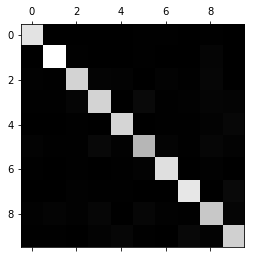

In [45]:
## Image representation of plot matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
conf_mx

array([[5728,    2,   25,    8,   11,   48,   51,    7,   40,    3],
       [   2, 6444,   50,   25,    6,   46,    7,   10,  138,   14],
       [  56,   40, 5332,  104,   84,   22,   92,   49,  166,   13],
       [  51,   37,  141, 5336,    2,  229,   33,   58,  142,  102],
       [  23,   22,   44,   12, 5366,   11,   49,   36,   77,  202],
       [  79,   37,   37,  204,   69, 4582,  115,   31,  169,   98],
       [  35,   24,   48,    2,   40,   88, 5622,    5,   53,    1],
       [  23,   13,   70,   27,   51,   11,    5, 5816,   21,  228],
       [  52,  125,   71,  159,   13,  154,   58,   30, 5043,  146],
       [  43,   28,   26,   86,  175,   29,    2,  216,   85, 5259]])

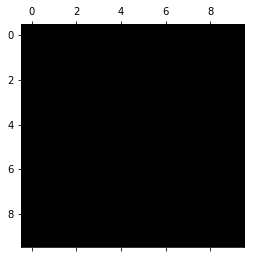

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

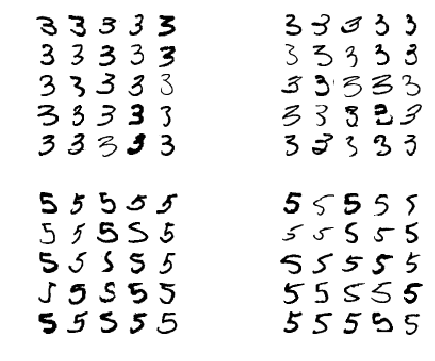

In [48]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 6))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [52]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.96826098556329954

### Multioutput Classification

In [53]:
import numpy.random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [54]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')

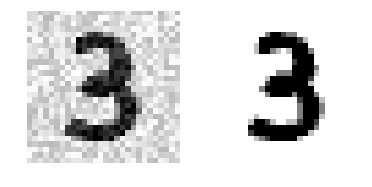

In [55]:
index = 4000
plt.subplot(121); plot_digit(X_test_mod[index])
plt.subplot(122); plot_digit(y_test_mod[index])
plt.show()

In [56]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[index]])

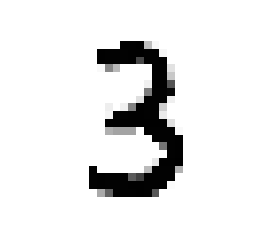

In [63]:
plot_digit(clean_digit)
plt.show()

## Exercises

1. Try to build a classifier for the MINIST dataset that achieves over 97% accuracy on the test set. 

__Hint:__ the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameters values (try a grid search on the weights and n_neighbors hyperparameters)

2. Write a function

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [2]:
import pandas as pd
import os
base_path = 'titanic'
gender_path = os.path.join(base_path, 'gender_submission.csv')
test_path = os.path.join(base_path, 'test.csv')
train_path = os.path.join(base_path, 'train.csv')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

#train.groupby('Pclass').Survived.mean().plot(kind='bar')
X_train = train[['Pclass']]
y_train = train['Survived']
X_test = test[['Pclass']]

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
pred = tree.predict(X_test)

test.set_index(['PassengerId'], inplace=True)
test.head()
dfTest = pd.DataFrame(data=pred, index = test.index.values, columns=["Survived"])
dfTest.to_csv('titanic/pred1.csv', sep=',')

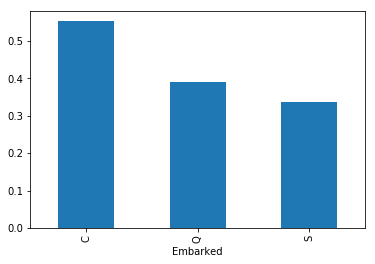

In [25]:
train.groupby('Embarked').Survived.mean().plot(kind='bar')
plt.show()

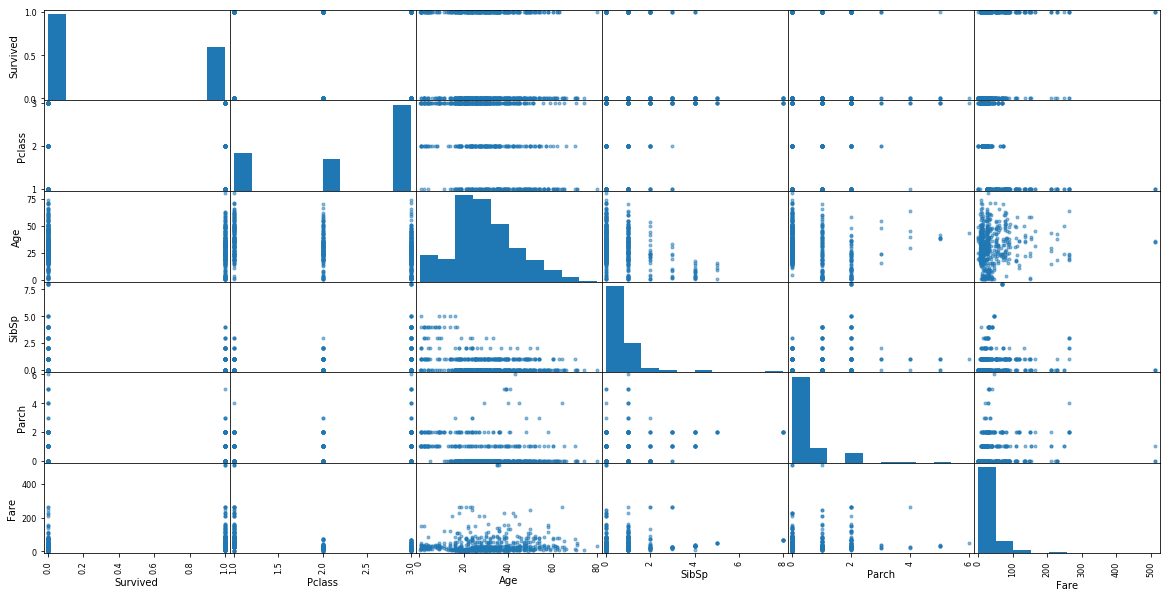

In [31]:
from pandas.tools.plotting import scatter_matrix
attr = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
scatter_matrix(train[attr], figsize=(20,10))
plt.show()

In [18]:
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
m = train.corr()
m['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [73]:
from sklearn.preprocessing import LabelEncoder
attr = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
en = LabelEncoder()
d = train[attr]
en.fit_transform(d.ix[0])

array([2, 4, 1, 0, 3])

In [68]:
from sklearn.pipeline import Pipeline


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64